In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

img_size = 256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Using device: cuda


In [ ]:
def load_model(model_path, num_classes):
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint, strict=False)  
    model = model.to(device).eval()
    return model

def predict_image(image, model, class_names):
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        confidence, predicted = torch.max(probabilities, 0)

    predicted_label = class_names[predicted.item()]
    return predicted_label, confidence.item()

def display_prediction(image, label, confidence):
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)", fontsize=14, color="blue")
    plt.show()


In [ ]:
def detect_hand(image, border_padding=0.2):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    mp_draw = mp.solutions.drawing_utils
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)
    
    cropped_hands = []

    if result.multi_hand_landmarks:
        for landmarks in result.multi_hand_landmarks:
            h, w, _ = image.shape
            x_min, y_min = min([landmark.x for landmark in landmarks.landmark]), min([landmark.y for landmark in landmarks.landmark])
            x_max, y_max = max([landmark.x for landmark in landmarks.landmark]), max([landmark.y for landmark in landmarks.landmark])
            
            x_min, y_min = int(x_min * w), int(y_min * h)
            x_max, y_max = int(x_max * w), int(y_max * h)
            
            width, height = x_max - x_min, y_max - y_min
            padding_x = int(width * border_padding)
            padding_y = int(height * border_padding)
            
            x_min = max(0, x_min - padding_x)
            y_min = max(0, y_min - padding_y)
            x_max = min(w, x_max + padding_x)
            y_max = min(h, y_max + padding_y)
            
            cropped_hand = image[y_min:y_max, x_min:x_max]
            cropped_hands.append(cropped_hand)

    return cropped_hands if cropped_hands else None


/tmp/ipykernel_155412/2171067250.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Prediction - I (100.00%)


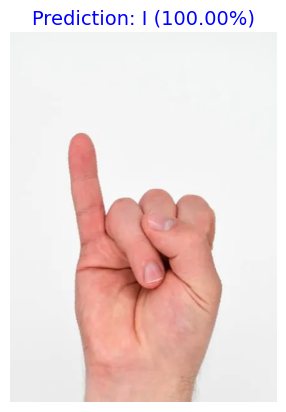

In [ ]:
if __name__ == "__main__":
    image_model_path = "/home/mostafabakr/Desktop/Project X/Final_models/asl_image_model.pth"
    test_image_path = "/home/mostafabakr/Desktop/Project X/Test_img/i-sign-language-008d47e6-989ee559-1920w.webp"

    image_class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
    num_image_classes = len(image_class_names)

    image_model = load_model(image_model_path, num_image_classes)

    image = cv2.imread(test_image_path)

    hand_images = detect_hand(image, border_padding=0.6)  # 0.3-0.5- 0.6 -0.7

    if hand_images is not None:
        for i, hand_image in enumerate(hand_images):
            hand_image_pil = Image.fromarray(cv2.cvtColor(hand_image, cv2.COLOR_BGR2RGB))

            predicted_label, confidence = predict_image(hand_image_pil, image_model, image_class_names)

            print(f"Prediction - {predicted_label} ({confidence * 100:.2f}%)")
            display_prediction(hand_image_pil, predicted_label, confidence)
    else:
        print("No hands detected in the image.")
